# Regression with MNIST-1D

In order to make our lives a bit easier, we will use a simplified dataset called [MNIST1D](https://github.com/greydanus/mnist1d). This dataset is small and yet exposes quite some intricacies.

In [1]:
import pickle
from pathlib import Path

In [2]:
import lightning as L
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import torch

# set the seeds to make the notebook reproducible
L.seed_everything(41)

Seed set to 41


41

Download the MNIST1d demo dataset at [this URL](https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl) using your browser
or download the dataset directly from this notebook by uncommenting the following lines:

In [4]:
# import requests
# with open('mnist1d_data.pkl', 'wb') as out_file:
#    out_file.write(requests.get('https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl').content)

In [5]:
# load the dataset into this notebook
output = Path("./mnist1d_data.pkl")
data = pickle.load(output.open("rb"))

## Step 1: Visualize dataset

The dataset is inspired by the original MNIST dataset, but it is way smaller and 1D only.

In [6]:
x = data["x"]
y = data["y"]
x_test = data["x_test"]
y_test = data["y_test"]
t = data["t"]  # not needed here
print(f"shapes of x {x.shape, x.dtype} and y {y.shape, y.dtype} for training")
print(f"shapes of x {x_test.shape} and y {y_test.shape} for testing")

shapes of x ((13500, 24), dtype('float64')) and y ((13500,), dtype('int64')) for training
shapes of x (1500, 24) and y (1500,) for testing


## Step 2: Normalisation

The signal in the mnist1d dataset is not normalized. We need to perform normalisation before we can proceed. We choose a min-max normalisation.

In [7]:
xmin, xmax = x.min(), x.max()
print(f"min/max of x: {xmin, xmax}")

min/max of x: (-3.95753393168845, 4.098753451896514)


In [8]:
x_ = (x - xmin) / (xmax - xmin)
x_test_ = (x_test - xmin) / (
    xmax - xmin
)  # Note: we need to apply the same normalisation constants to the test set

print(
    f"normalisation: raw min/max {x.min(), x.max()} -> normed min/max {x_.min(), x_.max()}"
)
print(x_.shape, x_test_.shape)

normalisation: raw min/max (-3.95753393168845, 4.098753451896514) -> normed min/max (0.0, 1.0)
(13500, 24) (1500, 24)


## Step 3: prepare training

Torch is a bit peculiar with respect to the encoding of the the signals. We need to inject a dimension in all data in order to continue.

In [9]:
# 1D Convolutions are special, they need an additional axis inserted
# which represents the number of channels being present
x_ = np.expand_dims(x_, axis=1)
assert x_.shape == (
    x.shape[0],
    1,
    x.shape[-1],
), f"{x_.shape} does not match {x.shape[0], 1, x.shape[-1]}"
x_test_ = np.expand_dims(x_test_, axis=1)
y = np.expand_dims(y, axis=1)
y_test = np.expand_dims(y_test, axis=1)

print(f"shapes of x {x_.shape} and y {y.shape} for training")
print(f"shapes of x {x_test_.shape} and y {y_test.shape} for testing")

shapes of x (13500, 1, 24) and y (13500, 1) for training
shapes of x (1500, 1, 24) and y (1500, 1) for testing


Let's create a simple 1D regression training set by computing the sum across all input channels. Thus, we will have

- `x` - signals from mnist1d
- `y` - the sum of mnist1d for a given `x`

(13500, 1, 1) (1500, 1, 1)


Text(0, 0.5, 'sum(x)')

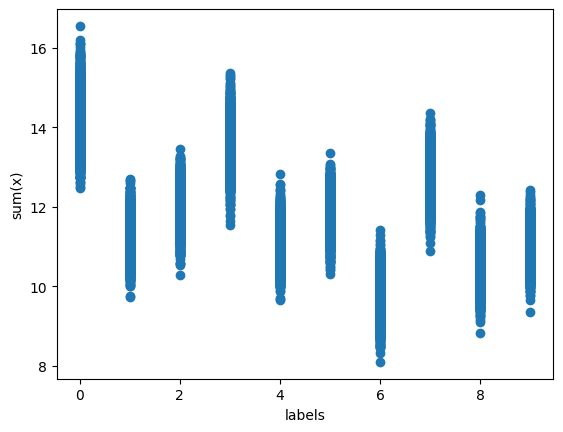

In [10]:
# Let's create a 1D training set by using the sum of the signal as regression target
y_ = np.expand_dims(np.sum(x_, axis=-1), axis=-1)
y_test_ = np.expand_dims(np.sum(x_test_, axis=-1), axis=-1)

# adding a bit of data noise for demonstrative purposes
y_ *= np.random.randn(*y_.shape) / 25.0 + 1.0
y_test_ *= np.random.randn(*y_test_.shape) / 25.0 + 1.0

print(y_.shape, y_test_.shape)
plt.scatter(np.squeeze(y), np.squeeze(y_))
plt.xlabel("labels")
plt.ylabel("sum(x)")

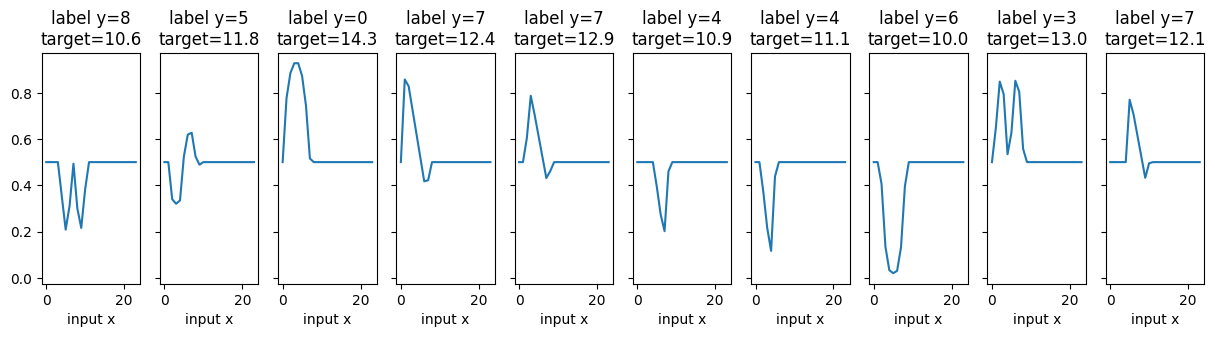

In [11]:
# let's plot the result, use the first 10 samples
n = 10
xaxis = np.arange(0, x_.shape[-1], 1)
fig, ax = plt.subplots(1, n, figsize=(15, 3), sharey=True)
for i in range(n):
    ax[i].plot(xaxis, x_[i, 0, ...], label="original")
    ax[i].set_title(f"label y={y[i,0]}\ntarget={y_[i,0,0]:02.1f}")
    ax[i].set_xlabel(f"input x")

Convert everything to a `torch.Tensor` object.

In [12]:
x_, y = torch.tensor(x_, dtype=torch.float32), torch.tensor(y_, dtype=torch.float32)

In [13]:
x_test_, y_test = torch.tensor(x_test_, dtype=torch.float32), torch.tensor(
    y_test_, dtype=torch.float32
)

# creating the model

In [14]:
def create_mlp(
    inshape: tuple = x_.shape, channels: int = 2 * x_.shape[-1], dropout: float = 0.3
):
    """Creates a simple multi-layer perceptron (MLP) to regress the signal.

    Parameters
    ----------
    inshape : tuple, optional
        The input shape of the MLP, by default x_.shape
    channels : int, optional
        The number of channels in the MLP, by default 2*x_.shape[-1]
    dropout : float, optional
        The dropout rate for the MLP, by default 0.3

    Returns
    -------
    torch.nn.Sequential
        A PyTorch sequential model for the MLP.

    Notes
    -----
    This model is adopted from https://github.com/greydanus/mnist1d/blob/39dd6c03785eefe60f349af94e61f864fc449644/models.py#L36

    Examples
    --------
    >>> x = torch.randn(100, 28, 28)
    >>> model = create_mlp(inshape=x.shape)
    >>> y = model(x)
    """

    return torch.nn.Sequential(
        torch.nn.Linear(inshape[-1], channels),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=dropout),
        torch.nn.Linear(channels, 1),
        torch.nn.ReLU(),
    )

In [15]:
# create a mlp model to show that the code works
mlp = create_mlp(x_.shape, channels=48, dropout=0.65)
mlp

Sequential(
  (0): Linear(in_features=24, out_features=48, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.65, inplace=False)
  (3): Linear(in_features=48, out_features=1, bias=True)
  (4): ReLU()
)

In [16]:
# check if mlp model prediction works
print(x_[:2, 0].shape)
mlp(x_[:2, 0]).shape

torch.Size([2, 24])


torch.Size([2, 1])

In [17]:
def fit_model(
    data_train,
    data_val,
    model,
    optimizer_cls,
    scheduler_cls=None,
    loss_fn=torch.nn.MSELoss(),
    batch_size=64,
    epochs=25,
    validation_interval=1,
):
    """run the training loop"""

    optimizer = optimizer_cls(model.parameters())
    scheduler = scheduler_cls(optimizer) if scheduler_cls else None

    train_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(data_train[0], data_train[1]),
        batch_size=batch_size,
        shuffle=True,
    )

    val_loader = torch.utils.data.DataLoader(
        torch.utils.data.TensorDataset(data_val[0], data_val[1]),
        batch_size=batch_size,
        shuffle=False,
    )

    train_losses = []
    val_losses = []
    for epoch in range(epochs):
        epoch_losses_train = train_epoch(model, train_loader, optimizer, loss_fn)

        avg_train_loss = np.mean(epoch_losses_train)
        train_losses.append((epoch, avg_train_loss))

        if epoch % validation_interval == 0:
            epoch_losses_val = run_validation(model, val_loader, loss_fn)

            avg_val_loss = np.mean(epoch_losses_val)
            val_losses.append((epoch, avg_val_loss))
            print(
                f"{scheduler.get_last_lr()} Epoch {epoch+1}/{epochs}: Train loss={avg_train_loss:02.04f}, Validation_loss={avg_val_loss:02.04f}"
            )
            if scheduler and hasattr(scheduler, "step"):
                scheduler.step(avg_val_loss)
        else:
            print(f"Epoch {epoch+1}/{epochs}: Train loss={avg_train_loss:02.04f}")

    return train_losses, val_losses


def train_epoch(model, train_loader, optimizer, loss_fn):
    """perform one training epoch"""
    model.train()
    epoch_losses_train = []
    for train_batch in train_loader:
        inputs, labels = train_batch
        labels_pred = model(inputs)

        loss = loss_fn(labels_pred, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses_train.append(loss.detach().cpu().numpy())

    return epoch_losses_train


def run_validation(model, val_loader, loss_fn):
    """perform one validation run"""
    model.eval()

    epoch_losses_val = []
    with torch.no_grad():
        for val_batch in val_loader:
            inputs, labels = val_batch
            labels_pred = model(inputs)

            val_loss = loss_fn(labels_pred, labels)
            epoch_losses_val.append(val_loss.detach().cpu().numpy())

    return epoch_losses_val


def init_weights(m):
    if isinstance(m, torch.nn.Linear) or isinstance(m, torch.nn.Conv1d):
        # torch.nn.init.normal_(m.weight, .1,.01)
        torch.nn.init.kaiming_normal_(m.weight)
        m.bias.data.fill_(0.01)

## Perform Training

In [18]:
from functools import partial

In [19]:
optimizer_cls = partial(torch.optim.Adam, lr=0.001, betas=(0.9, 0.999), eps=1.0e-7)
scheduler_cls = partial(
    torch.optim.lr_scheduler.ReduceLROnPlateau, mode="min", patience=5
)
loss_fn = torch.nn.MSELoss()

In [20]:
batch_size = 32
epochs = 35
validation_interval = 1  # every how many epochs should we run validation

In [21]:
model = create_mlp(x_.shape, channels=128, dropout=0.35)
model.apply(init_weights)

train_losses, val_losses = fit_model(
    # data_train=(x_[:batch_size,...], y[:batch_size,...]),
    data_train=(x_, y),
    data_val=(x_test_, y_test),
    # data_val=(x_[:batch_size,...], y[:batch_size,...]),
    model=model,
    optimizer_cls=optimizer_cls,
    scheduler_cls=scheduler_cls,
    loss_fn=loss_fn,
    batch_size=batch_size,
    epochs=epochs,
    validation_interval=validation_interval,
)

[0.001] Epoch 1/35: Train loss=10.9334, Validation_loss=0.2463
[0.001] Epoch 2/35: Train loss=1.6477, Validation_loss=0.2409
[0.001] Epoch 3/35: Train loss=1.5059, Validation_loss=0.2334
[0.001] Epoch 4/35: Train loss=1.4214, Validation_loss=0.2363
[0.001] Epoch 5/35: Train loss=1.3903, Validation_loss=0.2238
[0.001] Epoch 6/35: Train loss=1.3253, Validation_loss=0.2217
[0.001] Epoch 7/35: Train loss=1.3396, Validation_loss=0.2243
[0.001] Epoch 8/35: Train loss=1.3179, Validation_loss=0.3005
[0.001] Epoch 9/35: Train loss=1.2766, Validation_loss=0.2646
[0.001] Epoch 10/35: Train loss=1.2607, Validation_loss=0.2574
[0.001] Epoch 11/35: Train loss=1.2548, Validation_loss=0.2383
[0.001] Epoch 12/35: Train loss=1.2478, Validation_loss=0.2483
[0.0001] Epoch 13/35: Train loss=1.2057, Validation_loss=0.2214
[0.0001] Epoch 14/35: Train loss=1.1745, Validation_loss=0.2249
[0.0001] Epoch 15/35: Train loss=1.1970, Validation_loss=0.2311
[0.0001] Epoch 16/35: Train loss=1.2007, Validation_loss=0.2

In [22]:

import pandas as pd
import seaborn as sns


def plot_history(train_losses, val_losses, legend=True, lossname="L1"):
    """
    Plot the training history
    """

    train_epochs = [tup[0] for tup in train_losses]
    train_l = [tup[1] for tup in train_losses]

    val_epochs = [tup[0] for tup in val_losses]
    val_l = [tup[1] for tup in val_losses]

    history_df = pd.DataFrame()
    history_df["Epoch"] = train_epochs + val_epochs
    history_df[lossname] = train_l + val_l
    history_df["Subset"] = ["Training"] * len(train_epochs) + ["Validation"] * len(
        val_epochs
    )

    sns.lineplot(
        data=history_df,
        x="Epoch",
        y=lossname,
        hue="Subset",
        legend="auto" if legend else False,
    )

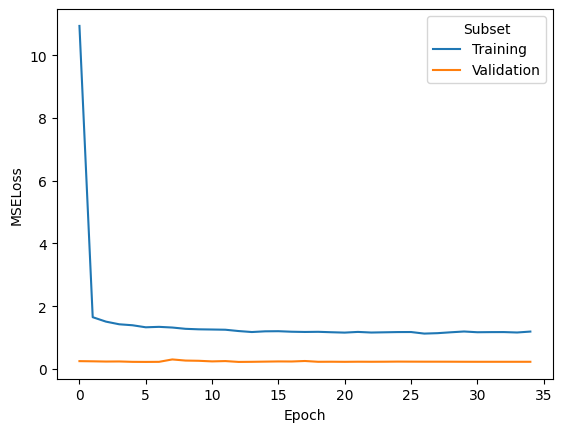

In [23]:
plot_history(train_losses, val_losses, lossname=str(loss_fn.__class__.__name__))

torch.Size([1500]) torch.Size([1500, 1, 1])


Text(0.5, 0, 'labels')

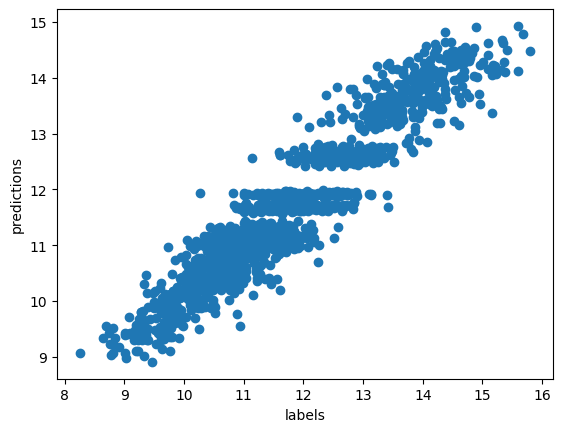

In [24]:
with torch.no_grad():
    pred = model(x_test_).squeeze()
print(pred.shape, y_test.shape)

plt.scatter(y_test.squeeze().numpy(), pred.numpy())
plt.ylabel("predictions")
plt.xlabel("labels")

The above is not a great model, but it should suffice for the sake of the demonstration.

## Create a mcdropout based estimate

The idea of MCDropout was first proposed by Yarin Gal et al in 2015, see the original here
https://arxiv.org/abs/1506.02142



In [25]:
num_predictors = 32
n = 20
model.train()  ## NOTE: we keep dropout layers in train mode even though we are doing inference (key idea of MCDropout)
predictions = []
with torch.no_grad():
    for pidx in range(num_predictors):
        predictions.append(model(x_test_[:n, ...]).detach().cpu().numpy())
predictions = np.concatenate(predictions, axis=1)

# check the shape of the predictions of our MCDropout ensemble
print(predictions.shape)

(20, 32, 1)


In [26]:
mean_pred = np.mean(predictions, axis=1)
median_pred = np.median(predictions, axis=1)
std_pred = np.std(predictions, axis=1)

# check the shape of the summary statistics of the MCDropout ensemble
print(mean_pred.shape, std_pred.shape)

(20, 1) (20, 1)


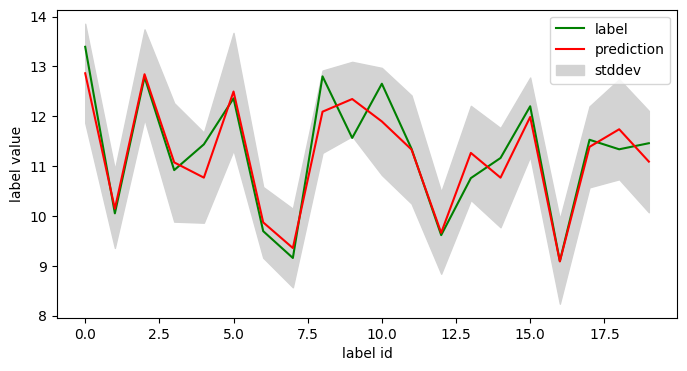

In [27]:
from matplotlib.lines import Line2D

xaxis = np.arange(n)

fig, ax = plt.subplots(1, 1, figsize=(8, 4))
ax.plot(xaxis, y_test[:n].squeeze(), label="label", color="g")
ax.plot(xaxis, mean_pred.squeeze(), label="prediction", color="r")

ax.fill_between(
    xaxis,
    mean_pred.squeeze() + std_pred.squeeze(),
    mean_pred.squeeze() - std_pred.squeeze(),
    color="lightgrey",
    label="stddev",
)
ax.set_xlabel("label id")
ax.set_ylabel("label value")
ax.legend()

In [28]:
# now predictions for all of the test data
inference_loader = torch.utils.data.DataLoader(
    torch.utils.data.TensorDataset(x_test_, y_test),
    batch_size=batch_size,
    shuffle=False,
)

model.train()  ## NOTE: we keep dropout layers in train mode even though we are doing inference
y_predictions = []
with torch.no_grad():
    for batch in inference_loader:
        batch_x, _ = batch  # n_samples x 1 x 24
        predictions_batch = np.concatenate(
            [model(batch_x).detach().cpu().numpy() for pidx in range(num_predictors)],
            axis=1,
        )  # n_samples x n_predictors x 24
        y_predictions.append(predictions_batch)
y_predictions = np.concatenate(y_predictions, axis=0)
print(y_predictions.shape)

(1500, 32, 1)


# Calibration plots

An important aspect of uncertainty quantification is to assess if the predictive uncertainties are of high quality. We will use a library called `uncertainty-toolbox` for this. It will lift the burdon for certain (tricky) operations from our fingers. The [project's landing page](https://github.com/uncertainty-toolbox/uncertainty-toolbox) will provide more details.

In [29]:
from uncertainty_toolbox.viz import plot_calibration

y_mean = np.squeeze(np.mean(y_predictions, axis=1, keepdims=True))
y_std = np.squeeze(np.std(y_predictions, axis=1, keepdims=True))
print(y_mean.shape, y_std.shape, y_test.numpy().shape)

(1500,) (1500,) (1500, 1, 1)


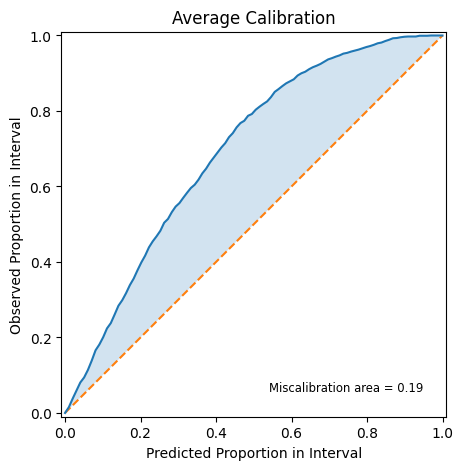

In [30]:
ax = plot_calibration(
    y_mean.flatten(), y_std.flatten(), y_test.squeeze().numpy().flatten()
)

As the calibration curve is below the diagonal, we would consider this MCDroput approximation quite bad and unusable. The miscalibration area is very large and we see many entries below the diagonal. This suggests that our predictor is overdispersed/underconfident, i.e. when the predicted "uncertainty" should be `0.4` say, the observed uncertainty is much higher (around `0.7`). In other words, the predictor suggestes the uncertainty to be too high.

## Task: Repeat the above with different model parameters

Repeat the exercise above, but this time play around with the model definition a bit.

- Can you find a variant of the MLP that performs better/worse with respect to the final validation loss?
- if you have found such a variant, what happens to the calibration plot?
